In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('consumer_durable.csv', index_col=['date'])
prices.head(10)

TITAN.NS  HAVELLS.NS   VOLTAS.NS  CROMPTON.NS  BATAINDIA.NS  \
date                                                                        
01-01-2018  852.450012  554.450012  648.950012   270.600006    755.299988   
02-01-2018  845.150024  549.250000  647.400024   277.799988    753.900024   
03-01-2018  856.299988  555.650024  643.599976   280.149994    772.400024   
04-01-2018  892.900024  562.849976  645.700012   282.950012    767.349976   
05-01-2018  909.700012  566.049988  646.349976   279.000000    764.799988   
08-01-2018  926.099976  563.099976  638.650024   273.950012    761.549988   
09-01-2018  932.950012  552.250000  648.599976   276.100006    746.900024   
10-01-2018  917.599976  549.700012  629.299988   270.500000    753.950012   
11-01-2018  906.900024  548.799988  625.849976   272.649994    749.700012   
12-01-2018  903.799988  549.099976  633.950012   272.250000    746.099976   

            KAJARIACER.NS  RAJESHEXPO.NS   RELAXO.NS  BLUESTARCO.NS  
date                                                                 
01-01-2018     725.099976     804.700012  343.424988     821.500000  
02-01-2018     712.950012     816.250000  335.450012     817.799988  
03-01-2018     736.950012     809.750000  343.000000     818.200012  
04-01-2018     743.700012     847.750000  340.200012     815.000000  
05-01-2018     750.849976     820.549988  339.774994     819.750000  
08-01-2018     748.150024     820.349976  336.875000     816.500000  
09-01-2018     753.000000     827.450012  337.274994     804.349976  
10-01-2018     747.599976     827.150024  339.950012     806.500000  
11-01-2018     742.000000     818.299988  337.600006     800.799988  
12-01-2018     739.549988     818.250000  339.024994     789.400024

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

TITAN.NS  HAVELLS.NS   VOLTAS.NS  CROMPTON.NS  BATAINDIA.NS  \
date                                                                         
01-01-2018   852.450012  554.450012  648.950012   270.600006    755.299988   
02-01-2018   845.150024  549.250000  647.400024   277.799988    753.900024   
30-12-2020  1552.599976  904.650024  819.799988   368.350006   1581.099976   
31-12-2020  1567.150024  916.150024  825.650024   380.549988   1579.650024   

            KAJARIACER.NS  RAJESHEXPO.NS   RELAXO.NS  BLUESTARCO.NS  
date                                                                 
01-01-2018     725.099976     804.700012  343.424988     821.500000  
02-01-2018     712.950012     816.250000  335.450012     817.799988  
30-12-2020     689.650024     486.799988  801.299988     801.549988  
31-12-2020     703.599976     490.549988  809.700012     801.099976

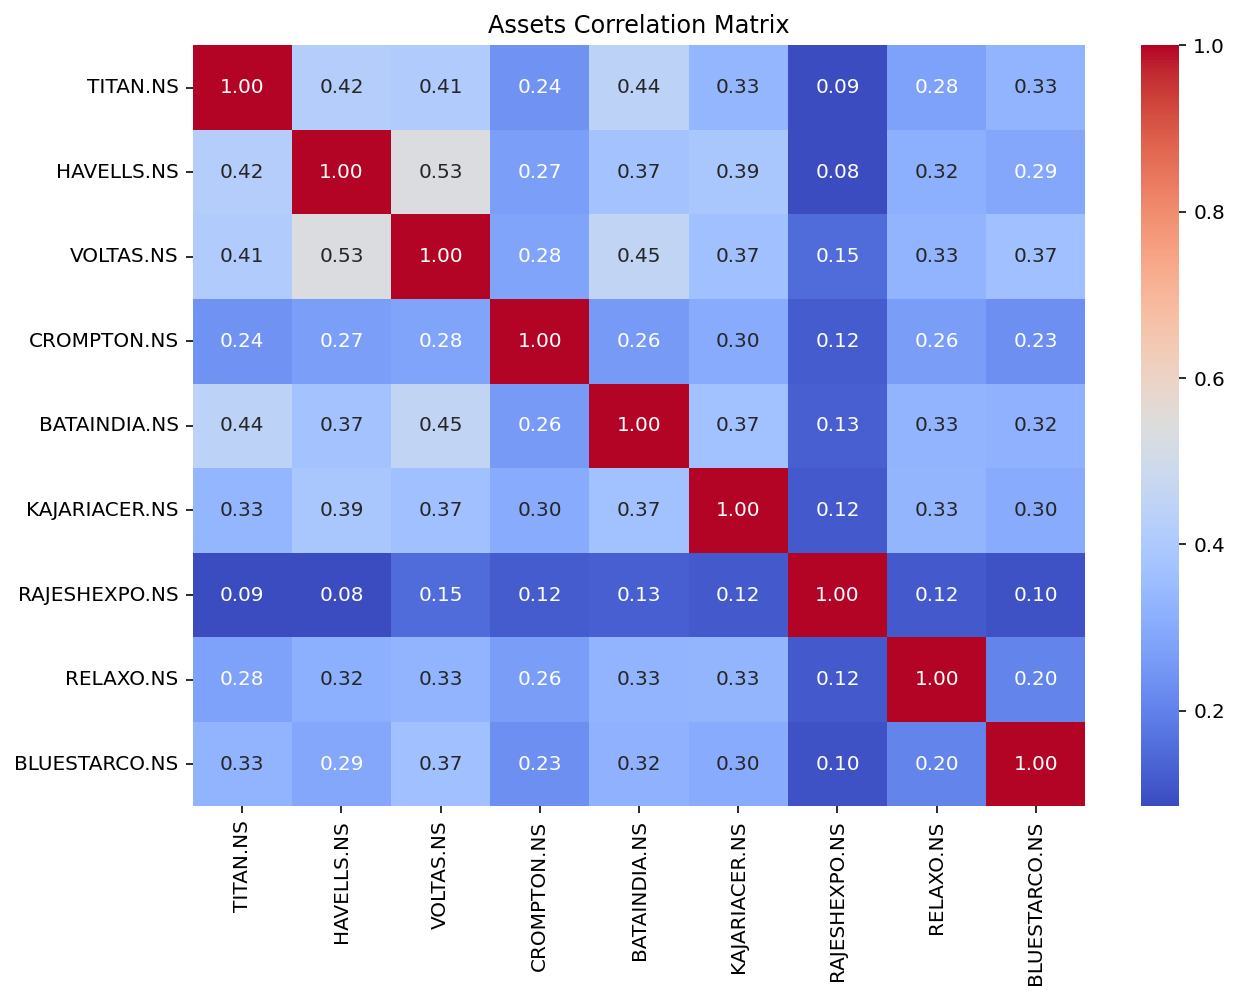

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('VOLTAS.NS', 'CROMPTON.NS')]


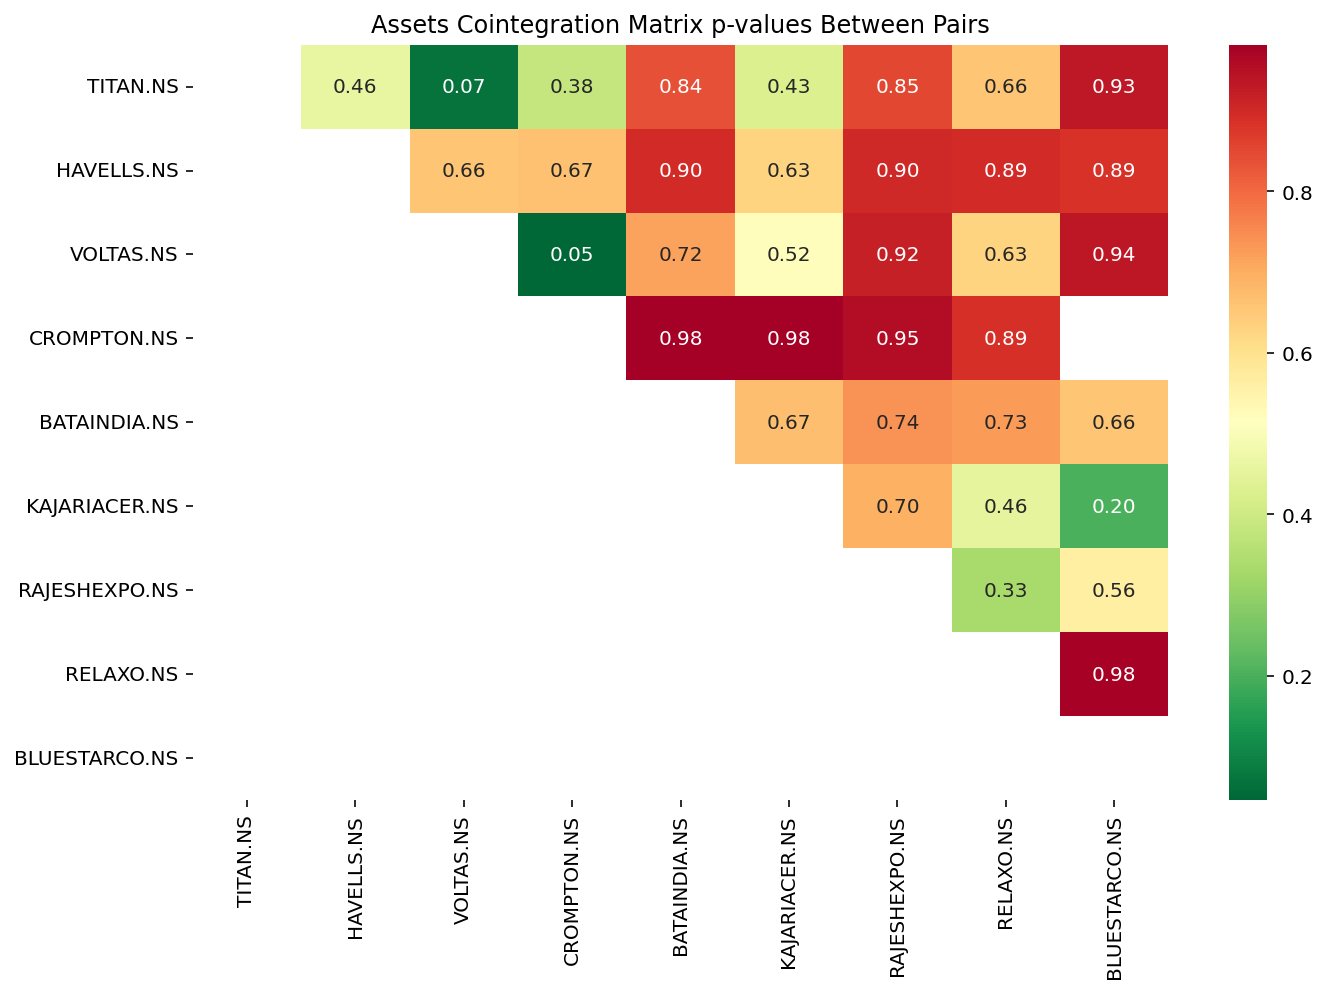

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'TITAN.NS'
asset2 = 'VOLTAS.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

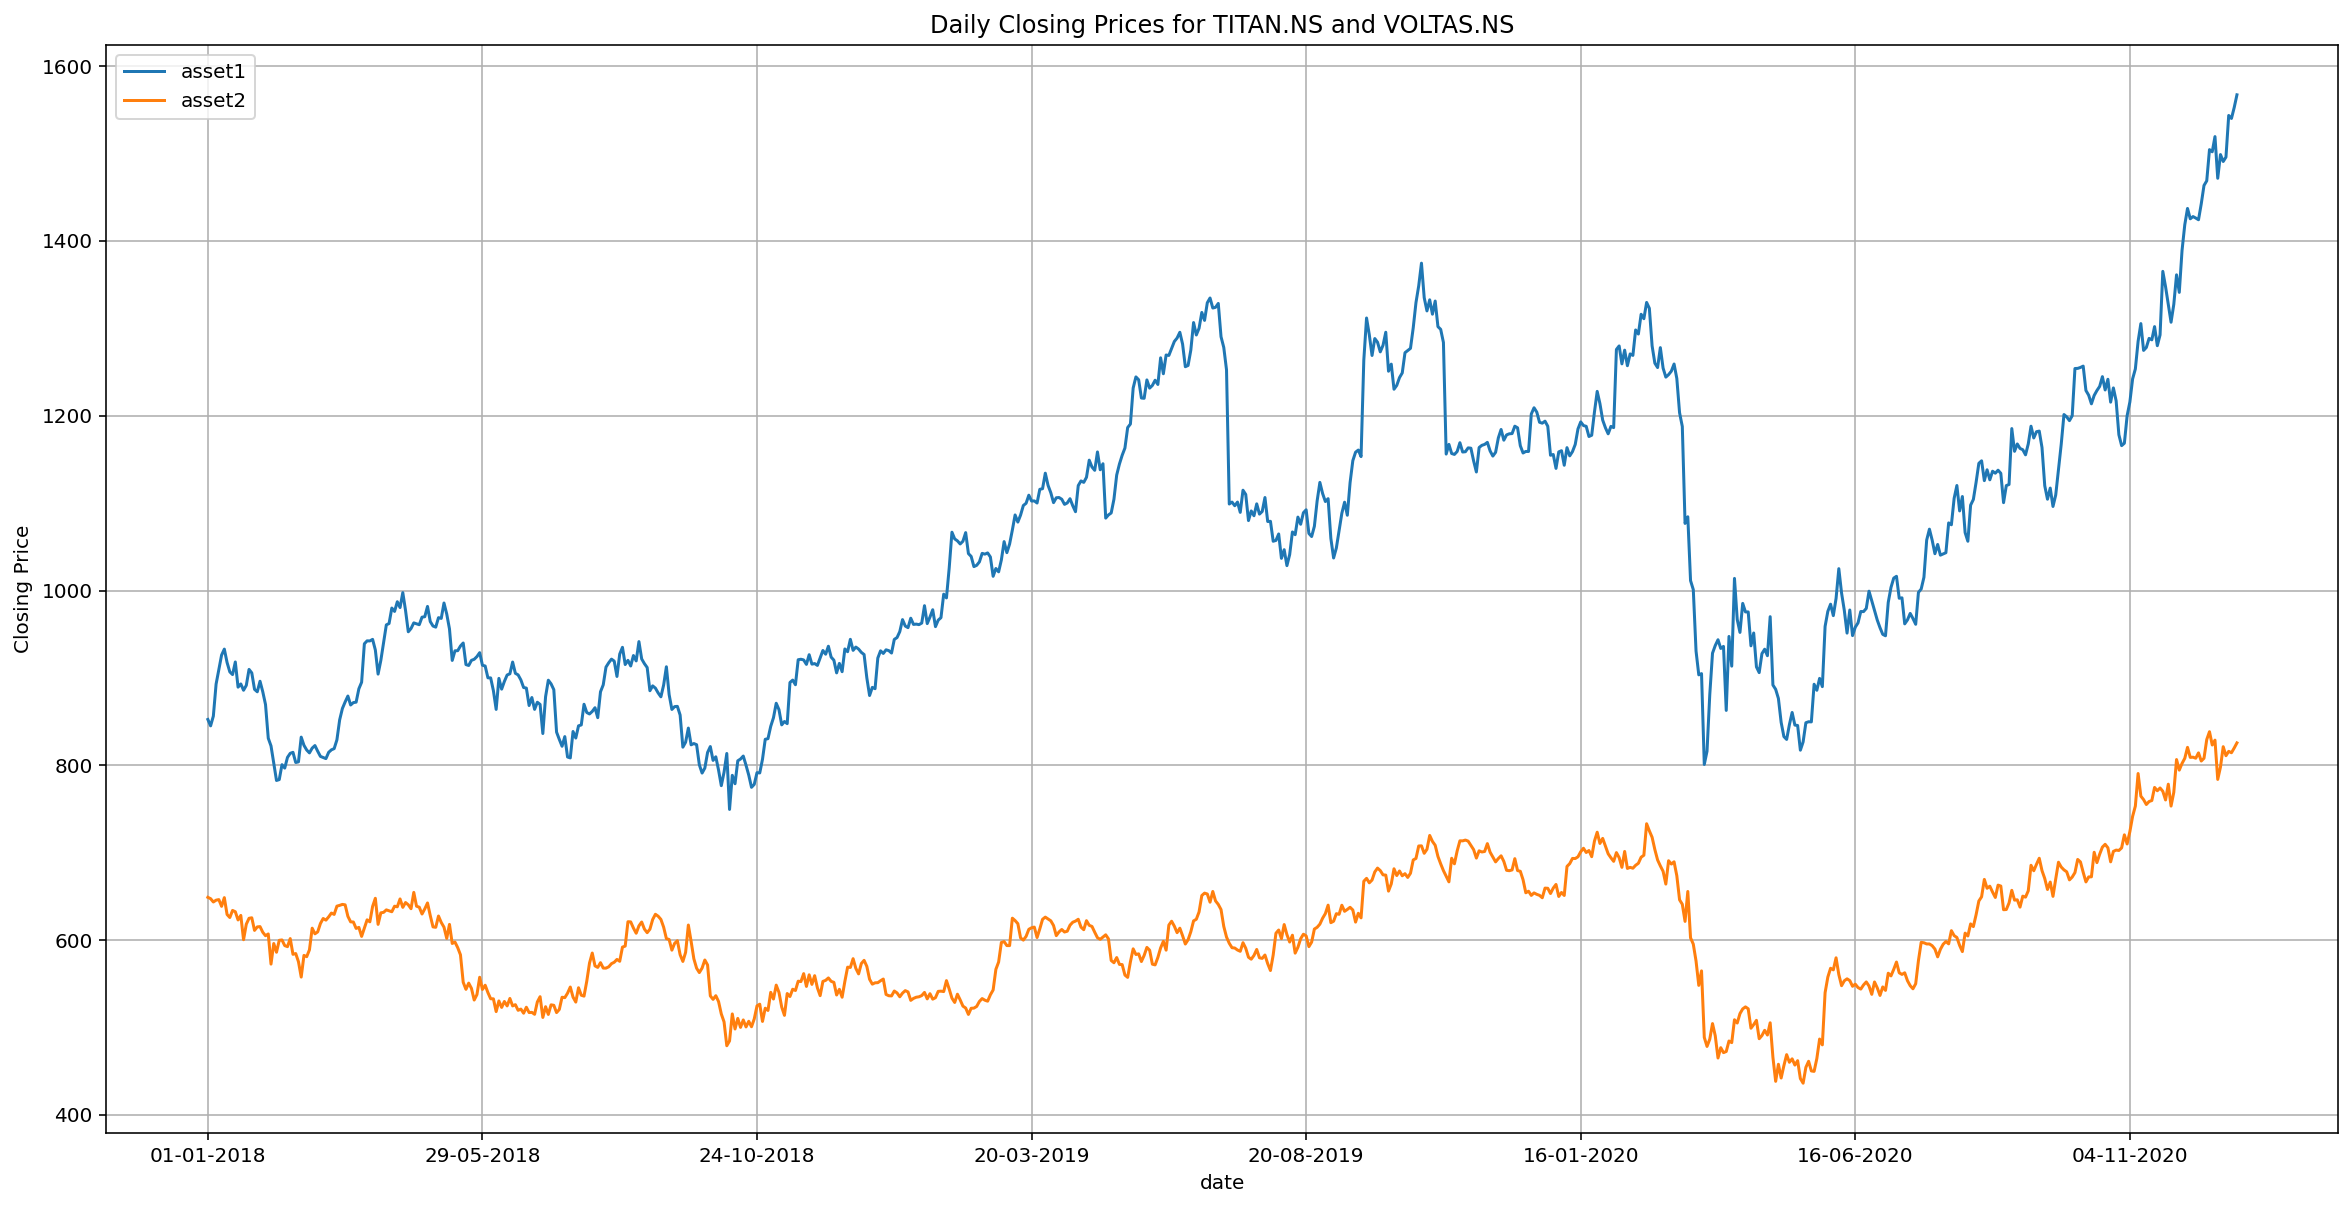

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          7.345e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        08:23:24   Log-Likelihood:                         -4096.3
No. Observations:                 740   AIC:                                      8195.
Df Residuals:                     739   BIC:                                      8199.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.5745      0.002    271.012      0.000       0.570       0.579
==============================================================================
Omnibus:                        6.697   Durbin-Watson:                   0.048
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.689
Skew:                           0.233   Prob(JB):                       0.0353
Kurtosis:                       3.020   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

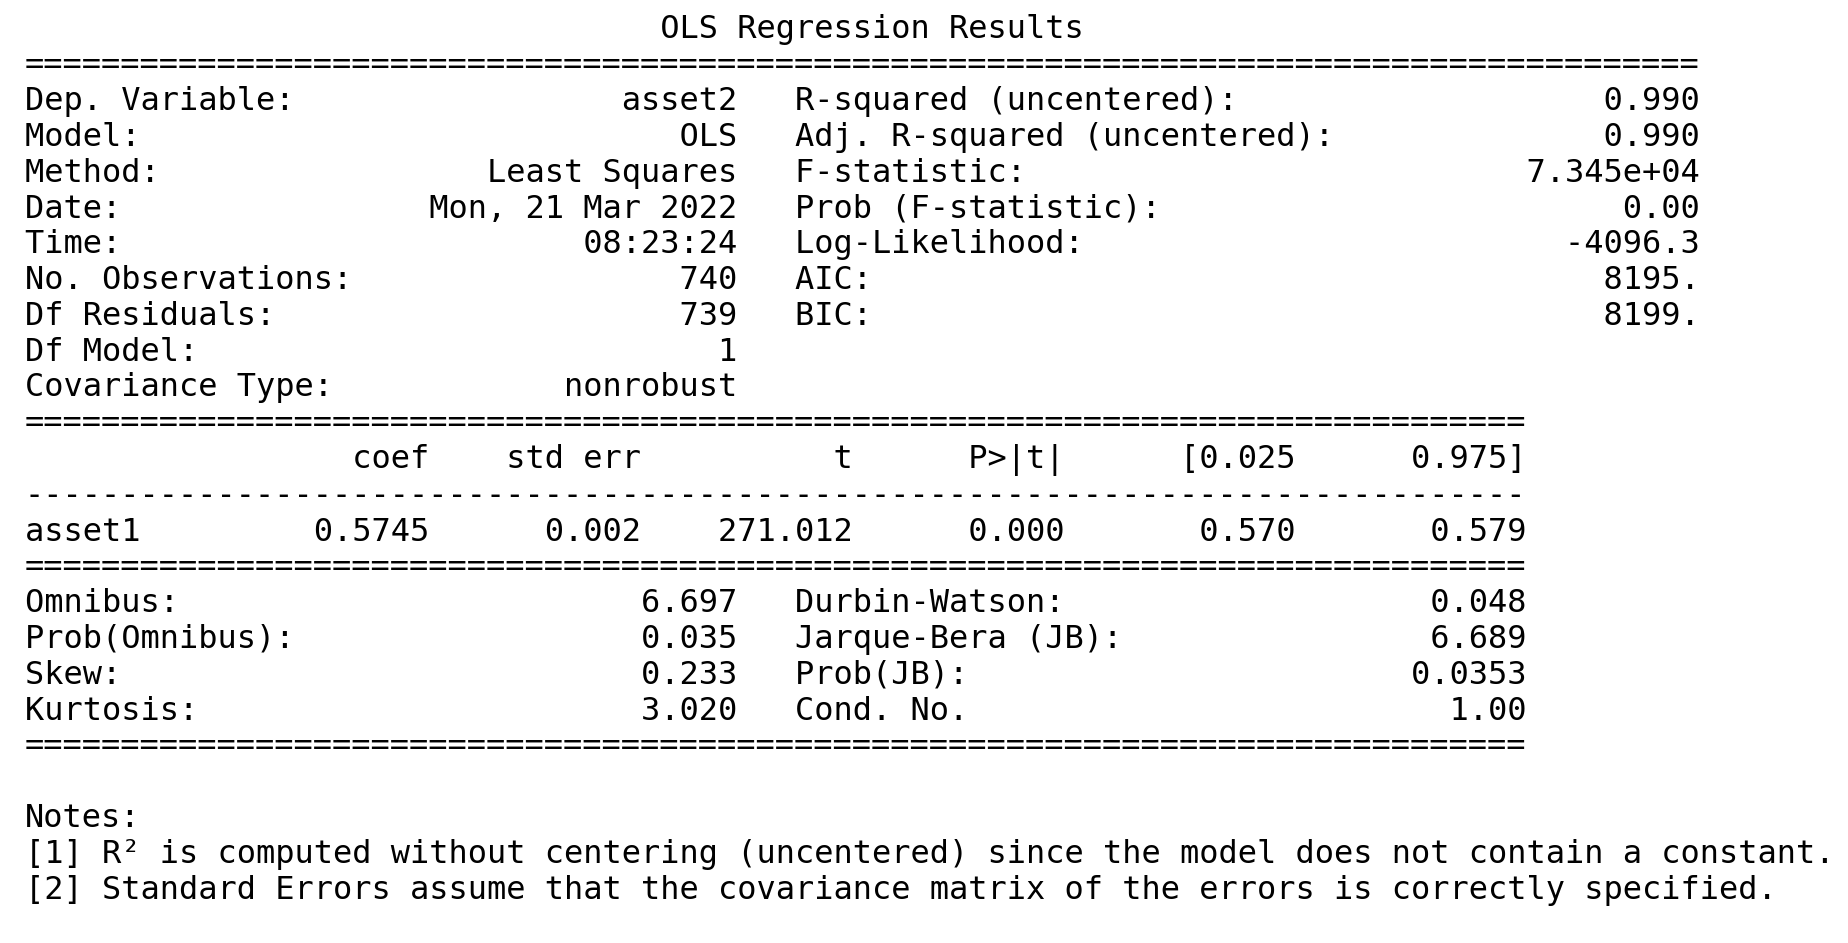

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.5744588454255075


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

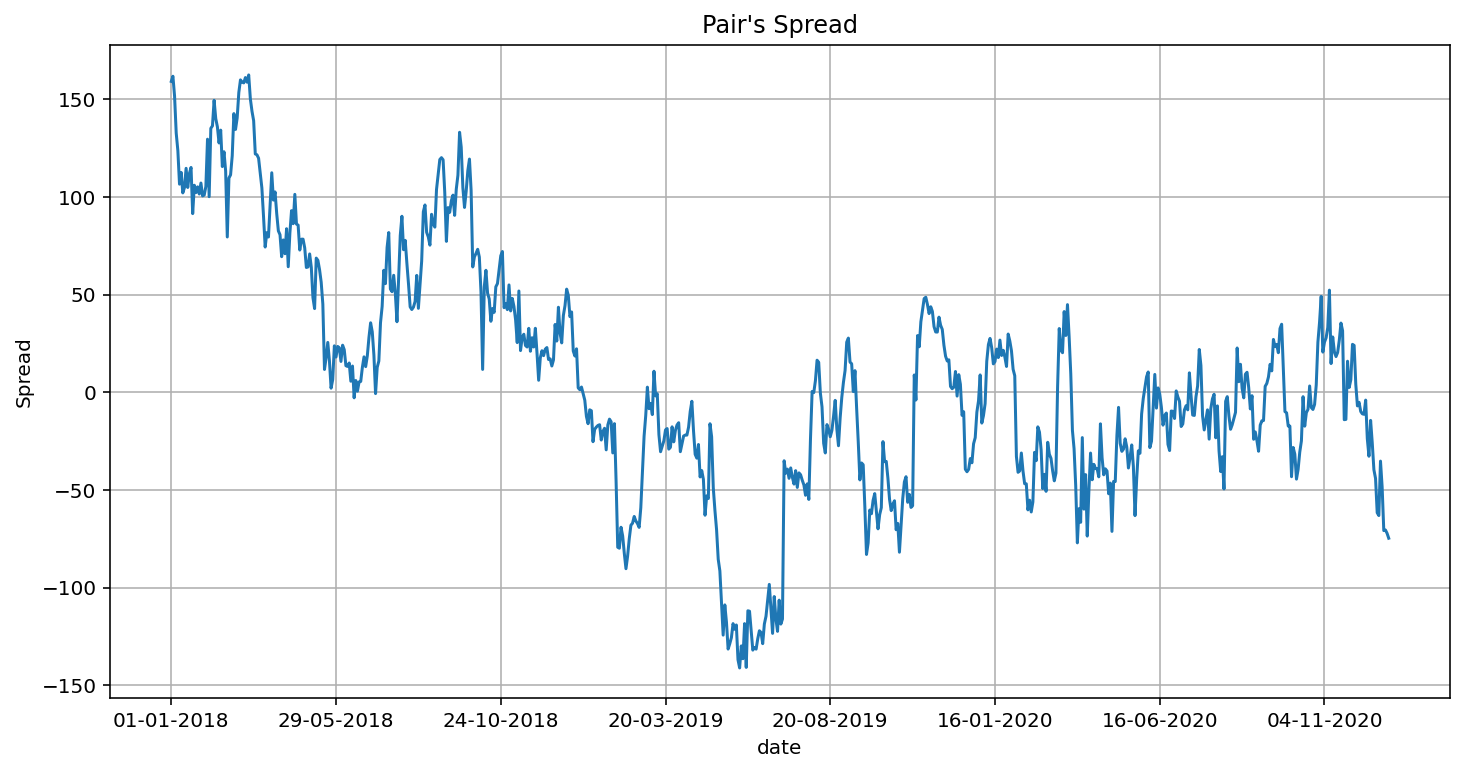

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.1742903909614717,
 0.021521922573302474,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 5917.182288269508)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.1742903909614717


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                               
01-01-2021  1558.599976  831.450012
04-01-2021  1550.900024  846.000000
05-01-2021  1570.949951  837.349976
06-01-2021  1572.599976  869.299988
07-01-2021  1542.349976  881.500000

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                       
01-01-2021  1558.599976  831.450012  0.892716            1.0           -1.0
04-01-2021  1550.900024  846.000000  0.677598            1.0           -1.0
05-01-2021  1570.949951  837.349976  0.900733            1.0           -1.0
06-01-2021  1572.599976  869.299988  0.551813            1.0           -1.0
07-01-2021  1542.349976  881.500000  0.242968            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

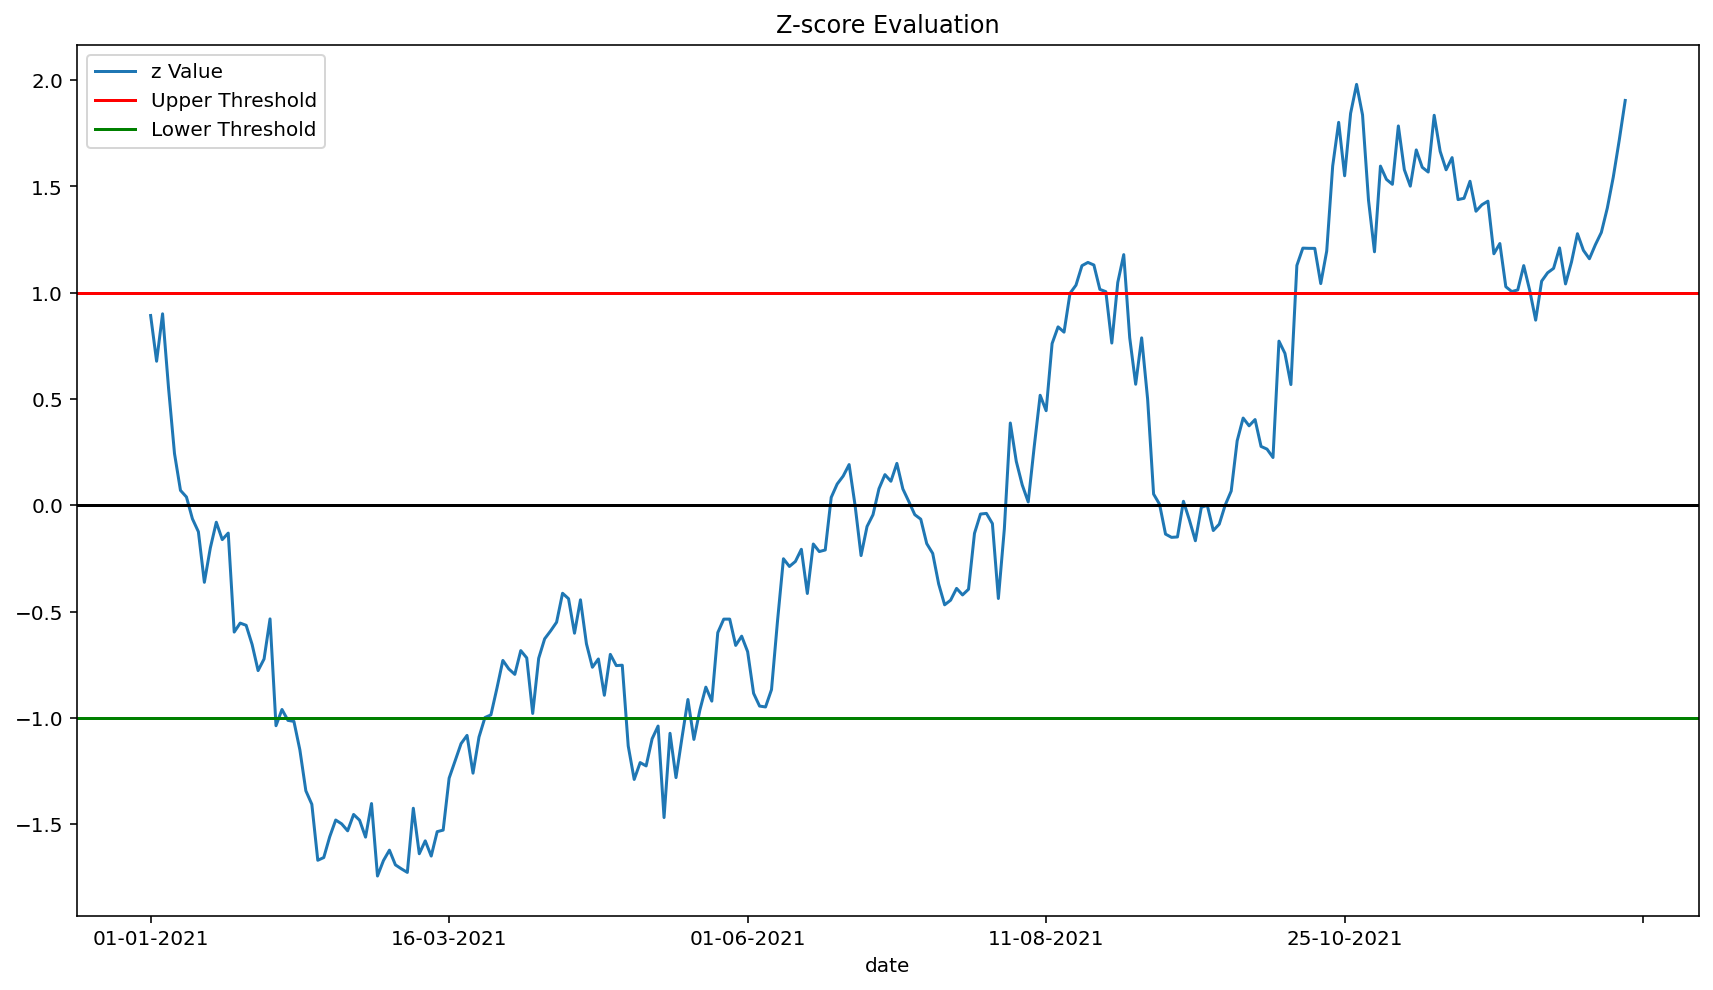

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1558.599976   831.450012  0.892716            1.0           -1.0   
04-01-2021  1550.900024   846.000000  0.677598            1.0           -1.0   
05-01-2021  1570.949951   837.349976  0.900733            1.0           -1.0   
29-12-2021  2402.149902  1201.250000  1.543939            1.0           -1.0   
30-12-2021  2437.300049  1198.800049  1.717776            1.0           -1.0   
31-12-2021  2522.399902  1219.150024  1.904403            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
02-02-2021  1485.449951   987.849976 -1.036915            1.0           -1.0   
04-02-2021  1513.599976  1003.349976 -1.011802            1.0           -1.0   
05-02-2021  1509.449951  1001.200012 -1.016514            1.0           -1.0   
08-02-2021  1541.699951  1040.400024 -1.150799            1.0           -1.0   
09-02-2021  1559.900024  1079.599976 -1.343050            1.0           -1.0   
10-02-2021  1563.150024  1091.050049 -1.406453            1.0           -1.0   
11-02-2021  1524.699951  1103.199951 -1.669914            1.0           -1.0   
12-02-2021  1494.199951  1079.199951 -1.657042            1.0           -1.0   
15-02-2021  1484.750000  1058.000000 -1.559159            1.0           -1.0   
16-02-2021  1471.849976  1037.650024 -1.480638            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
02-02-2021         1         1.0        -1        -1.0  
04-02-2021         1         1.0        -1        -1.0  
05-02-2021         1         0.0        -1         0.0  
08-02-2021         1         0.0        -1         0.0  
09-02-2021         1         0.0        -1         0.0  
10-02-2021         1         0.0        -1         0.0  
11-02-2021         1         0.0        -1         0.0  
12-02-2021         1         0.0        -1         0.0  
15-02-2021         1         0.0        -1         0.0  
16-02-2021         1         0.0        -1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1558.599976   831.450012  0.892716            1.0           -1.0   
02-02-2021  1485.449951   987.849976 -1.036915            1.0           -1.0   
03-02-2021  1525.150024  1004.450012 -0.960564            1.0           -1.0   
04-02-2021  1513.599976  1003.349976 -1.011802            1.0           -1.0   
24-03-2021  1488.150024   984.799988 -0.998415            1.0           -1.0   
30-08-2021  1878.449951   986.349976  1.048243            1.0           -1.0   
01-09-2021  1939.400024  1045.800049  0.788173            1.0           -1.0   
12-10-2021  2492.600098  1298.349976  1.128250            1.0           -1.0   
10-12-2021  2339.350098  1250.750000  0.870869            1.0           -1.0   
13-12-2021  2350.500000  1233.449951  1.054409            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
02-02-2021         1         1.0        -1        -1.0  
03-02-2021         0        -1.0         0         1.0  
04-02-2021         1         1.0        -1        -1.0  
24-03-2021         0        -1.0         0         1.0  
30-08-2021        -1        -1.0         1         1.0  
01-09-2021         0         1.0         0        -1.0  
12-10-2021        -1        -1.0         1         1.0  
10-12-2021         0         1.0         0        -1.0  
13-12-2021        -1        -1.0         1         1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

1485.449951    1
1513.599976    1
1423.949951    1
1521.150024    1
1822.550049    1
1939.400024    1
2339.350098    1
Name: asset1, dtype: int64

In [32]:
signals

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1558.599976   831.450012  0.892716            1.0           -1.0   
04-01-2021  1550.900024   846.000000  0.677598            1.0           -1.0   
05-01-2021  1570.949951   837.349976  0.900733            1.0           -1.0   
06-01-2021  1572.599976   869.299988  0.551813            1.0           -1.0   
07-01-2021  1542.349976   881.500000  0.242968            1.0           -1.0   
...                 ...          ...       ...            ...            ...   
27-12-2021  2331.300049  1195.750000  1.283488            1.0           -1.0   
28-12-2021  2379.850098  1207.000000  1.398233            1.0           -1.0   
29-12-2021  2402.149902  1201.250000  1.543939            1.0           -1.0   
30-12-2021  2437.300049  1198.800049  1.717776            1.0           -1.0   
31-12-2021  2522.399902  1219.150024  1.904403            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021        -1         0.0         1         0.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

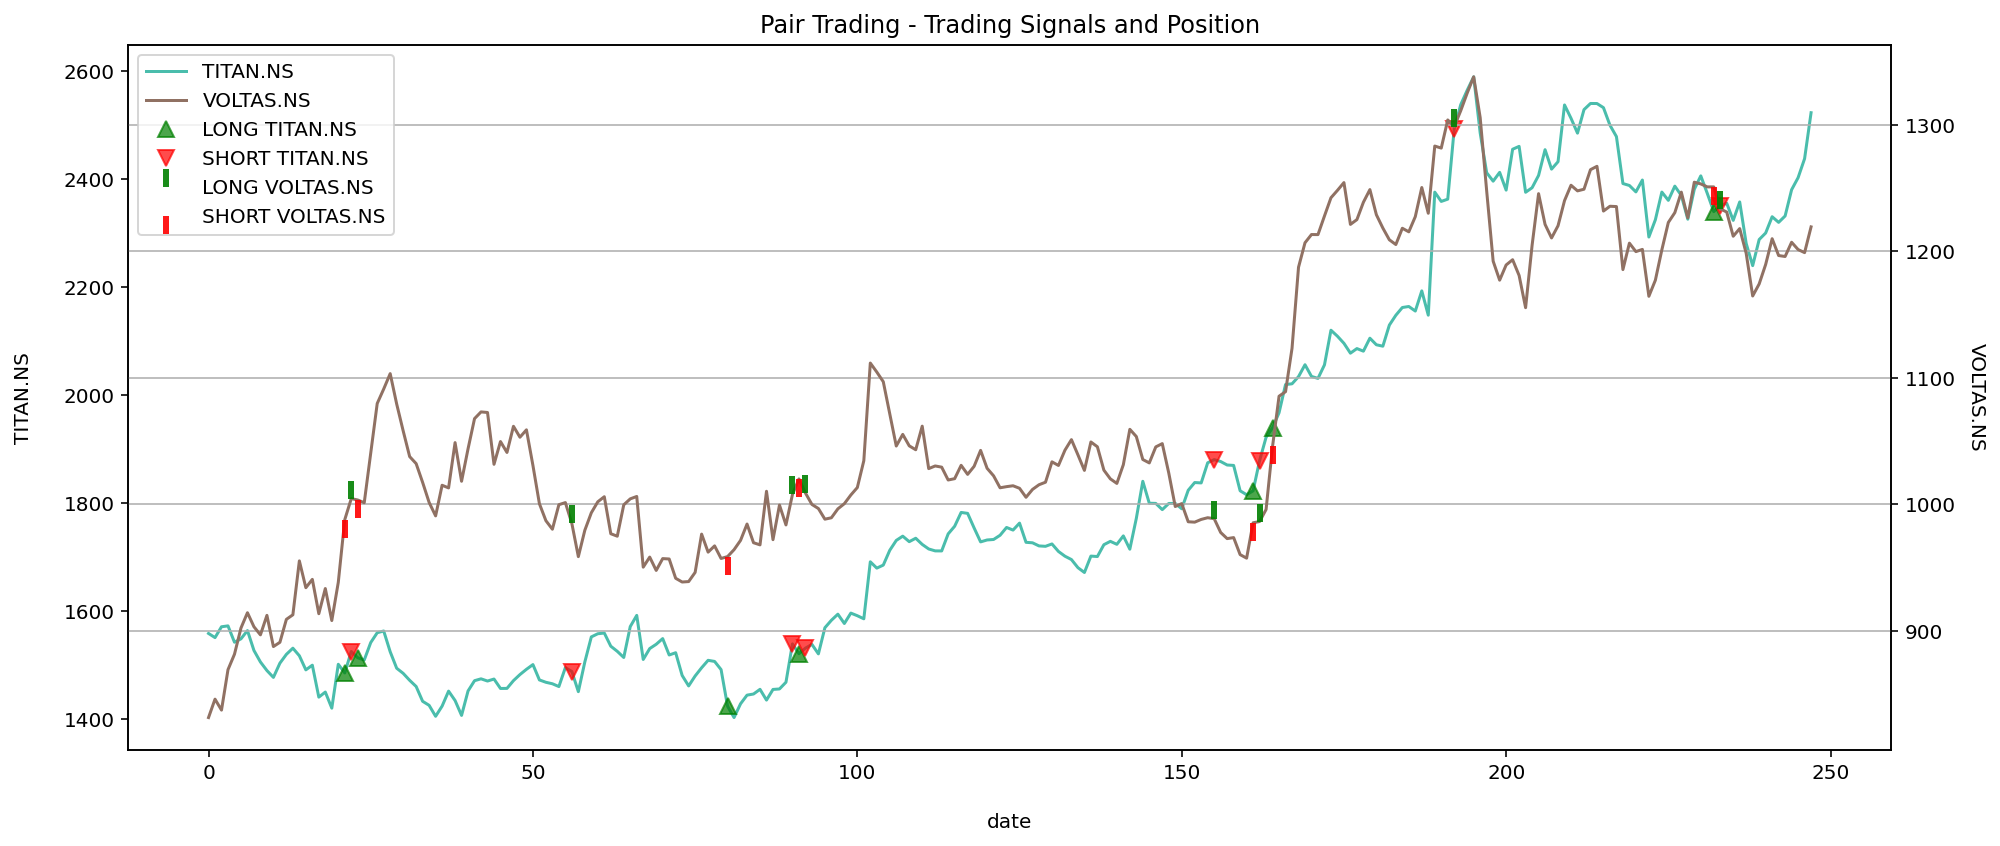

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1558.599976           NaN            NaN            NaN       NaN   
1    1550.900024      0.000000  100000.000000  100000.000000       NaN   
2    1570.949951      0.000000  100000.000000  100000.000000  0.000000   
3    1572.599976      0.000000  100000.000000  100000.000000  0.000000   
4    1542.349976      0.000000  100000.000000  100000.000000  0.000000   
243  2331.300049 -88589.401862  200331.401862  111742.000000 -0.004014   
244  2379.850098 -90434.303724  200331.401862  109897.098138 -0.016510   
245  2402.149902 -91281.696276  200331.401862  109049.705586 -0.007711   
246  2437.300049 -92617.401862  200331.401862  107714.000000 -0.012249   
247  2522.399902 -95851.196276  200331.401862  104480.205586 -0.030022   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   1558.599976           NaN            NaN            NaN       NaN   
21  1485.449951  56447.098138   43552.901862  100000.000000  0.000000   
22  1525.150024      0.000000  101508.602774  101508.602774  0.015086   
23  1513.599976  57516.799088   43991.803686  101508.602774  0.000000   
56  1488.150024      0.000000  100541.504598  100541.504598 -0.002714   

    positions1  
0          NaN  
21         1.0  
22        -1.0  
23         1.0  
56        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1558.599976           NaN            NaN            NaN       NaN   
1    1550.900024      0.000000  100000.000000  100000.000000       NaN   
2    1570.949951      0.000000  100000.000000  100000.000000  0.000000   
3    1572.599976      0.000000  100000.000000  100000.000000  0.000000   
4    1542.349976      0.000000  100000.000000  100000.000000  0.000000   
243  2331.300049 -88589.401862  200331.401862  111742.000000 -0.004014   
244  2379.850098 -90434.303724  200331.401862  109897.098138 -0.016510   
245  2402.149902 -91281.696276  200331.401862  109049.705586 -0.007711   
246  2437.300049 -92617.401862  200331.401862  107714.000000 -0.012249   
247  2522.399902 -95851.196276  200331.401862  104480.205586 -0.030022   

     positions1       asset2     holdings2          cash2   total asset2  \
0           NaN   831.450012           NaN            NaN            NaN   
1           0.0   846.000000      0.000000  100000.000000  100000.000000   
2           0.0   837.349976      0.000000  100000.000000  100000.000000   
3           0.0   869.299988      0.000000  100000.000000  100000.000000   
4           0.0   881.500000      0.000000  100000.000000  100000.000000   
243         0.0  1195.750000  88485.500000    6693.407296   95178.907296   
244         0.0  1207.000000  89318.000000    6693.407296   96011.407296   
245         0.0  1201.250000  88892.500000    6693.407296   95585.907296   
246         0.0  1198.800049  88711.203626    6693.407296   95404.610922   
247         0.0  1219.150024  90217.101776    6693.407296   96910.509072   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243 -0.000583         0.0  
244  0.008747         0.0  
245 -0.004432         0.0  
246 -0.001897         0.0  
247  0.015784         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   1558.599976           NaN            NaN            NaN       NaN   
21  1485.449951  56447.098138   43552.901862  100000.000000  0.000000   
22  1525.150024      0.000000  101508.602774  101508.602774  0.015086   
23  1513.599976  57516.799088   43991.803686  101508.602774  0.000000   
56  1488.150024      0.000000  100541.504598  100541.504598 -0.002714   

    positions1       asset2     holdings2          cash2   total asset2  \
0          NaN   831.450012           NaN            NaN            NaN   
21         1.0   987.849976 -73100.898194  173100.898194  100000.000000   
22        -1.0  1004.450012      0.000000   98771.597306   98771.597306   
23         1.0  1003.349976 -74247.898224  173019.495530   98771.597306   
56        -1.0   984.799988      0.000000  100144.296433  100144.296433   

         return2  positions2  
0            NaN         NaN  
21  2.220446e-16        -1.0  
22 -1.228403e-02         1.0  
23  2.220446e-16        -1.0  
56  1.234290e-02         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

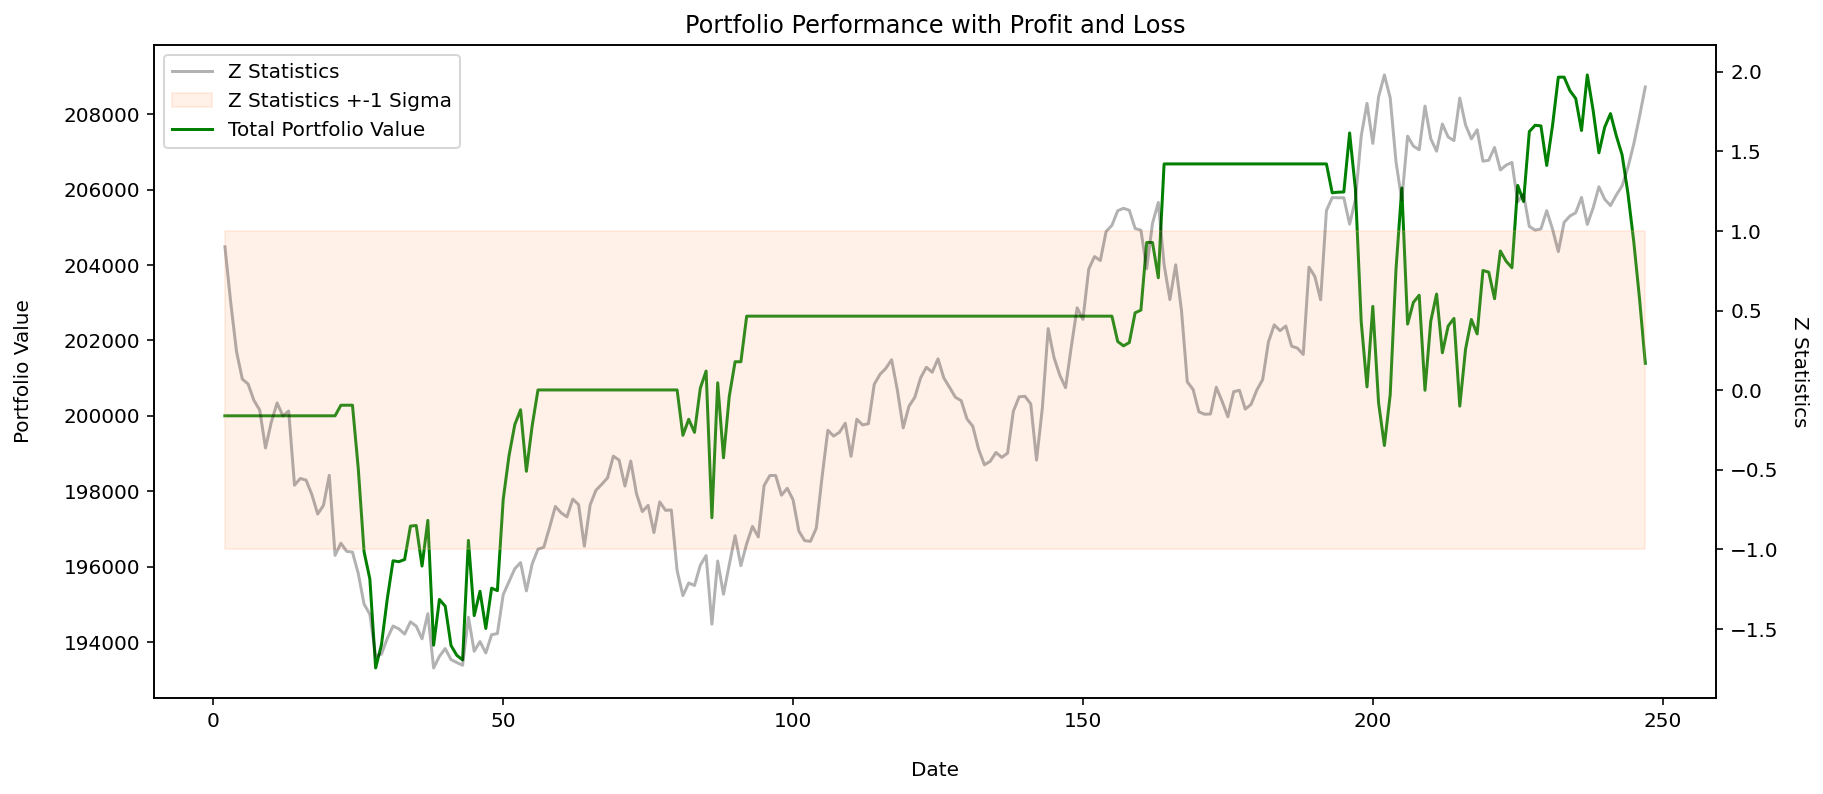

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [46]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

201390.7146584

In [47]:
profit = final_portfolio - 2*initial_capital
profit

1390.7146583999856

In [48]:
roi = (profit/(2*initial_capital))*100
roi

0.6953573291999928

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [45]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 183.764%
